In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# 构建文件路径
data_path = r'..\data_ec'
filename_lst = os.listdir(data_path)

In [3]:
# 数据保存数量
save_num = 24   # 只保留每组预报数据的前save_num个数据
#
dict_save = {}
utc_to_cst_offset = timedelta(hours=8)

for i, filename in enumerate(filename_lst):
    with open(os.path.join(data_path, filename), mode='rb') as f:
        dict_temp = pickle.load(f)
        #
        time_s_utc = pd.Timestamp(dict_temp['time_start'])
        time_e_utc = pd.Timestamp(dict_temp['time_end'])
        time_s_cst = time_s_utc + utc_to_cst_offset
        time_e_cst = time_e_utc + utc_to_cst_offset
        
        time_axis = pd.date_range(pd.Timestamp(time_s_cst), pd.Timestamp(time_e_cst), freq='h').to_numpy()[0: save_num]
        #
        element_lst = dict_temp['element_lst'][0:5] + dict_temp['element_lst'][6:]
        element_level_lst = dict_temp['element_level_lst'][0:5] + dict_temp['element_level_lst'][6:]
        #
        lon_lst = dict_temp['lon_lst']
        lat_lst = dict_temp['lat_lst']
        #
        for element_step in range(len(element_lst)):
            # 要素
            element = element_lst[element_step]
            # 要素对应的层数列表
            level_lst = element_level_lst[element_step]
            # 容器 维度顺序为(time, points, level)
            data_one_timestep = np.zeros((save_num, len(lon_lst), len(level_lst)))
            for point_step in range(len(lon_lst)):
                lon = lon_lst[point_step]
                lat = lat_lst[point_step]
                for level_step, level in enumerate(level_lst):
                    # print(element, '\t', lon, '\t', lat, '\t', time_s, '\t', level)
                    key_temp = 'variable:' + element + '&' + \
                               'lon:' + str(lon) + '&' + \
                               'lat:' + str(lat) + '&' + \
                               'time_start:' + str(time_s_utc.strftime('%Y-%m-%d %H:%M:%S')) + '&' + \
                               'level:' + str(level)
                    string_temp = dict_temp['data'][key_temp]
                    # 解构字符串-->转为数组
                    data_temp = np.array(string_temp[3:].split('|'), dtype=np.float64)
                    # 更新容器
                    data_one_timestep[:, point_step, level_step] = data_temp[: save_num].reshape(-1)
            # 更新字典
            if i == 0:
                dict_save[element] = {'data': data_one_timestep,
                                      'time': time_axis,
                                      'lon': lon_lst, 'lat': lat_lst,
                                      'level': level_lst,
                                      'info': "The dimension order of 'data' is (time, points(lon/lat), level), Respectively correspond to ('time', 'lon'/'lat', 'level').",}
            else:
                dict_save[element]['data'] = np.concatenate((dict_save[element]['data'], data_one_timestep), axis=0)
                dict_save[element]['time'] = np.concatenate((dict_save[element]['time'], time_axis), axis=0)

In [4]:
# # 数据保存数量
# save_num = 24   # 只保留每组预报数据的前save_num个数据
# #
# dict_save = {}
# 
# for i, filename in enumerate(filename_lst):
#     with open(os.path.join(data_path, filename), mode='rb') as f:
#         dict_temp = pickle.load(f)
#         #
#         time_s = dict_temp['time_start']
#         time_e = dict_temp['time_end']
#         time_axis = pd.date_range(pd.Timestamp(time_s), pd.Timestamp(time_e), freq='h').to_numpy()[0: save_num]
#         #
#         element_lst = dict_temp['element_lst'][0:5] + dict_temp['element_lst'][6:]
#         element_level_lst = dict_temp['element_level_lst'][0:5] + dict_temp['element_level_lst'][6:]
#         #
#         lon_lst = dict_temp['lon_lst']
#         lat_lst = dict_temp['lat_lst']
#         #
#         for element_step in range(len(element_lst)):
#             # 要素
#             element = element_lst[element_step]
#             # 要素对应的层数列表
#             level_lst = element_level_lst[element_step]
#             # 容器 维度顺序为(time, points, level)
#             data_one_timestep = np.zeros((save_num, len(lon_lst), len(level_lst)))
#             for point_step in range(len(lon_lst)):
#                 lon = lon_lst[point_step]
#                 lat = lat_lst[point_step]
#                 for level_step, level in enumerate(level_lst):
#                     # print(element, '\t', lon, '\t', lat, '\t', time_s, '\t', level)
#                     key_temp = 'variable:' + element + '&' + \
#                                'lon:' + str(lon) + '&' + \
#                                'lat:' + str(lat) + '&' + \
#                                'time_start:' + time_s + '&' + \
#                                'level:' + str(level)
#                     string_temp = dict_temp['data'][key_temp]
#                     # 解构字符串-->转为数组
#                     data_temp = np.array(string_temp[3:].split('|'), dtype=np.float64)
#                     # 更新容器
#                     data_one_timestep[:, point_step, level_step] = data_temp[: save_num].reshape(-1)
#             # 更新字典
#             if i == 0:
#                 dict_save[element] = {'data': data_one_timestep,
#                                       'time': time_axis,
#                                       'lon': lon_lst, 'lat': lat_lst,
#                                       'level': level_lst,
#                                       'info': "The dimension order of 'data' is (time, points(lon/lat), level), Respectively correspond to ('time', 'lon'/'lat', 'level').",}
#             else:
#                 dict_save[element]['data'] = np.concatenate((dict_save[element]['data'], data_one_timestep), axis=0)
#                 dict_save[element]['time'] = np.concatenate((dict_save[element]['time'], time_axis), axis=0)

In [5]:
dict_save.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape'])

In [6]:
dict_save['uwnd']['data'].shape

(10248, 2, 16)

In [7]:
dict_save['uwnd']['level'][:]

[1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100, 70, 50, 20, 10]

In [8]:
# 提取海威1号的'uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', level=1000
variables = ['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape']
data_1 = {}
for variable in variables:
    data_1[variable] = dict_save[variable]['data'][:, 0, 0]

In [9]:
data_1.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape'])

In [10]:
len(data_1['u10m'])

10248

In [11]:
#
time = dict_save['u10m']['time']
# 检查是否有遗漏的时间并构建时间轴方便后续插值
time_s = time[0]
time_e = time[-1]
time_axis_ec = pd.date_range(pd.Timestamp(time_s), pd.Timestamp(time_e), freq='h').to_numpy()
print(time_axis_ec.shape)

(10248,)


# 时间间隔为3h，截取

In [12]:
# 创建一个新的字典来存储时间间隔为3h的有效数据
filtered_dict = {}
#
for var_name, data_list in data_1.items():
    # 初始化一个新的列表来存储筛选后的数据点  
    filtered_data = []
    # 遍历数据点，每隔两个取一个  
    for i in range(0, len(data_list), 3):
        value = data_list[i]
        filtered_data.append(value)
    # 将筛选后的数据添加到新字典中  
    filtered_dict[var_name] = filtered_data

In [13]:
filtered_dict.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape'])

In [14]:
len(filtered_dict['uwnd'])

3416

In [15]:
# 截取间隔3h的时间轴
time_axis_3h = []
for i in range(0, len(time_axis_ec), 3):  # 每隔两个点取一个点（即每隔2小时取的实际是3小时间隔的点，因为原始数据是1小时间隔）  
    time_axis_3h.append(time_axis_ec[i])

In [16]:
len(time_axis_3h)

3416

# 剔除异常值

In [17]:
# 找出需要剔除的索引
indices_to_remove = {}
for variable, values in filtered_dict.items():
    values = np.array(values)
    if variable != 'visi':
        indices_to_remove[variable] = np.argwhere(np.abs(values) > 500)
    else:
        indices_to_remove[variable] = np.argwhere(values <= 0)

In [18]:
for var in indices_to_remove:
    print(var, len(indices_to_remove[var]))

uwnd 73
vwnd 73
temp 73
hght 73
rhum 73
lspe 489
sstk 73
t2mm 73
u10m 73
v10m 73
visi 489
t2md 73
cape 1794


In [19]:
indices_to_remove['uwnd']

array([[ 984],
       [ 985],
       [ 986],
       [ 988],
       [ 989],
       [ 990],
       [ 991],
       [ 992],
       [ 993],
       [ 994],
       [ 995],
       [ 996],
       [ 997],
       [ 998],
       [ 999],
       [1000],
       [1001],
       [1002],
       [1003],
       [1004],
       [1005],
       [1006],
       [1007],
       [1232],
       [1233],
       [1234],
       [1235],
       [1237],
       [1238],
       [1239],
       [1240],
       [1241],
       [1243],
       [1245],
       [1246],
       [1247],
       [1248],
       [1249],
       [1250],
       [1251],
       [1252],
       [1253],
       [1254],
       [1255],
       [1712],
       [1714],
       [1716],
       [1718],
       [1719],
       [1720],
       [1724],
       [1726],
       [1727],
       [1728],
       [1729],
       [1732],
       [1733],
       [1734],
       [1735],
       [1960],
       [1961],
       [1962],
       [1963],
       [1964],
       [1965],
       [1967],
       [19

In [20]:
# 依据索引剔除数据
filtered_dict_drop = {}
time_axis_drop = {}
for var in indices_to_remove:
    if var in filtered_dict:
        data = pd.DataFrame(filtered_dict[var])
        index = [item[0] for item in indices_to_remove[var]]
        filtered_dict_drop[var] = data.drop(index)
        
        time = pd.DataFrame(time_axis_3h)
        time_axis_drop[var] = time.drop(index)

In [21]:
for var in filtered_dict_drop:
    print(var, len(filtered_dict_drop[var]))

uwnd 3343
vwnd 3343
temp 3343
hght 3343
rhum 3343
lspe 2927
sstk 3343
t2mm 3343
u10m 3343
v10m 3343
visi 2927
t2md 3343
cape 1622


In [22]:
for var in time_axis_drop:
    print(var, len(time_axis_drop[var]))

uwnd 3343
vwnd 3343
temp 3343
hght 3343
rhum 3343
lspe 2927
sstk 3343
t2mm 3343
u10m 3343
v10m 3343
visi 2927
t2md 3343
cape 1622


In [23]:
(time_axis_drop['u10m'] == time_axis_drop['v10m']).all()

0    True
dtype: bool

In [24]:
# 依据风速分量u、v 合成速度大小velocity 和 风向degree
def get_vd(u, v):
    # 计算风速大小
    velocity = np.sqrt((u**2 + v**2))
    # 计算风向（以度表示）
    deg = 180.0/np.pi
    degrees = 180.0 + np.arctan2(u, v)*deg
    return velocity, degrees

In [25]:
# 计算矢量风速和方向
filtered_dict_drop['velocity10m'], filtered_dict_drop['degree10m'] = get_vd(filtered_dict_drop['u10m'], filtered_dict_drop['v10m'])

In [26]:
filtered_dict_drop.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', 'velocity10m', 'degree10m'])

In [27]:
time_axis_drop['velocity10m'] = time_axis_drop['u10m']
time_axis_drop['degree10m'] = time_axis_drop['u10m']

In [28]:
time_axis_drop.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', 'velocity10m', 'degree10m'])

## 线性插值

In [29]:
# 目标插值时间
time_axis_target = np.array(time_axis_3h).astype('int64')

In [30]:
#
interp_funcs = {}
interpolated_values = {}

for var in filtered_dict_drop:
    if var in time_axis_drop:
        
        interp_funcs[var] = interp1d(time_axis_drop[var].squeeze().astype('int64'), filtered_dict_drop[var].squeeze()
                                     , bounds_error=False)
        
        interpolated_values[var] = interp_funcs[var](time_axis_target)

In [31]:
interpolated_values.keys()

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', 'velocity10m', 'degree10m'])

In [32]:
for var in interpolated_values:
    print(var, interpolated_values[var].shape, np.isnan(interpolated_values[var]).any())

uwnd (3416,) False
vwnd (3416,) False
temp (3416,) False
hght (3416,) False
rhum (3416,) False
lspe (3416,) True
sstk (3416,) False
t2mm (3416,) False
u10m (3416,) False
v10m (3416,) False
visi (3416,) True
t2md (3416,) False
cape (3416,) True
velocity10m (3416,) False
degree10m (3416,) False


In [33]:
time_axis_target.shape

(3416,)

In [34]:
print(np.where(np.isnan(interpolated_values['lspe'])))
print(np.where(np.isnan(interpolated_values['visi'])))
print(np.where(np.isnan(interpolated_values['cape'])))

(array([0], dtype=int64),)
(array([0], dtype=int64),)
(array([   0, 3390, 3391, 3392, 3393, 3394, 3395, 3396, 3397, 3398, 3399,
       3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410,
       3411, 3412, 3413, 3414, 3415], dtype=int64),)


In [35]:
var_nan = ['lspe', 'visi', 'cape']

for var in var_nan:
    interpolated_values[var] = pd.DataFrame(interpolated_values[var]).ffill()
    interpolated_values[var] = pd.DataFrame(interpolated_values[var]).bfill()

In [36]:
print(np.where(np.isnan(interpolated_values['lspe'])))
print(np.where(np.isnan(interpolated_values['visi'])))
print(np.where(np.isnan(interpolated_values['cape'])))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [38]:
# 保存海威1号的时间轴
with open('../data_target_01/ec_time_axis.pkl', 'wb') as f:
    pickle.dump(time_axis_target, f)

In [39]:
# 保存海威1号的变量数据
with open('../data_target_01/ec_interpolated.pkl', 'wb') as f:
    pickle.dump(interpolated_values, f)

## 插值前后对比图

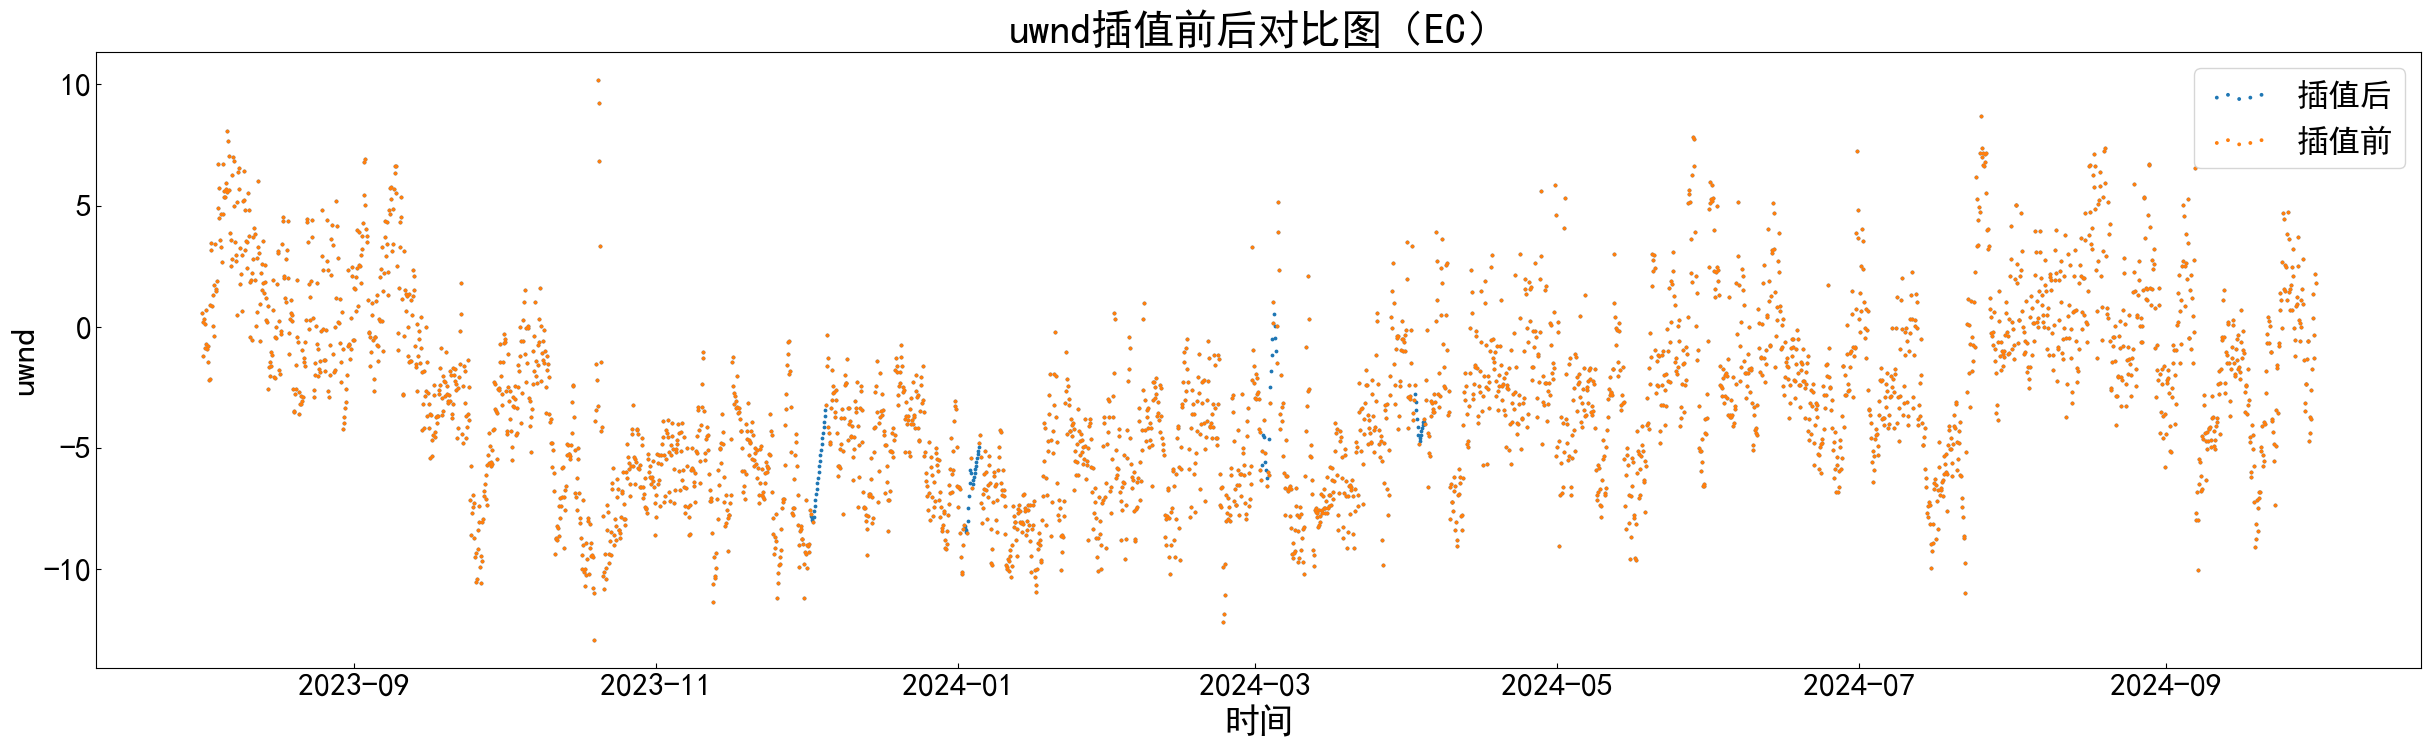

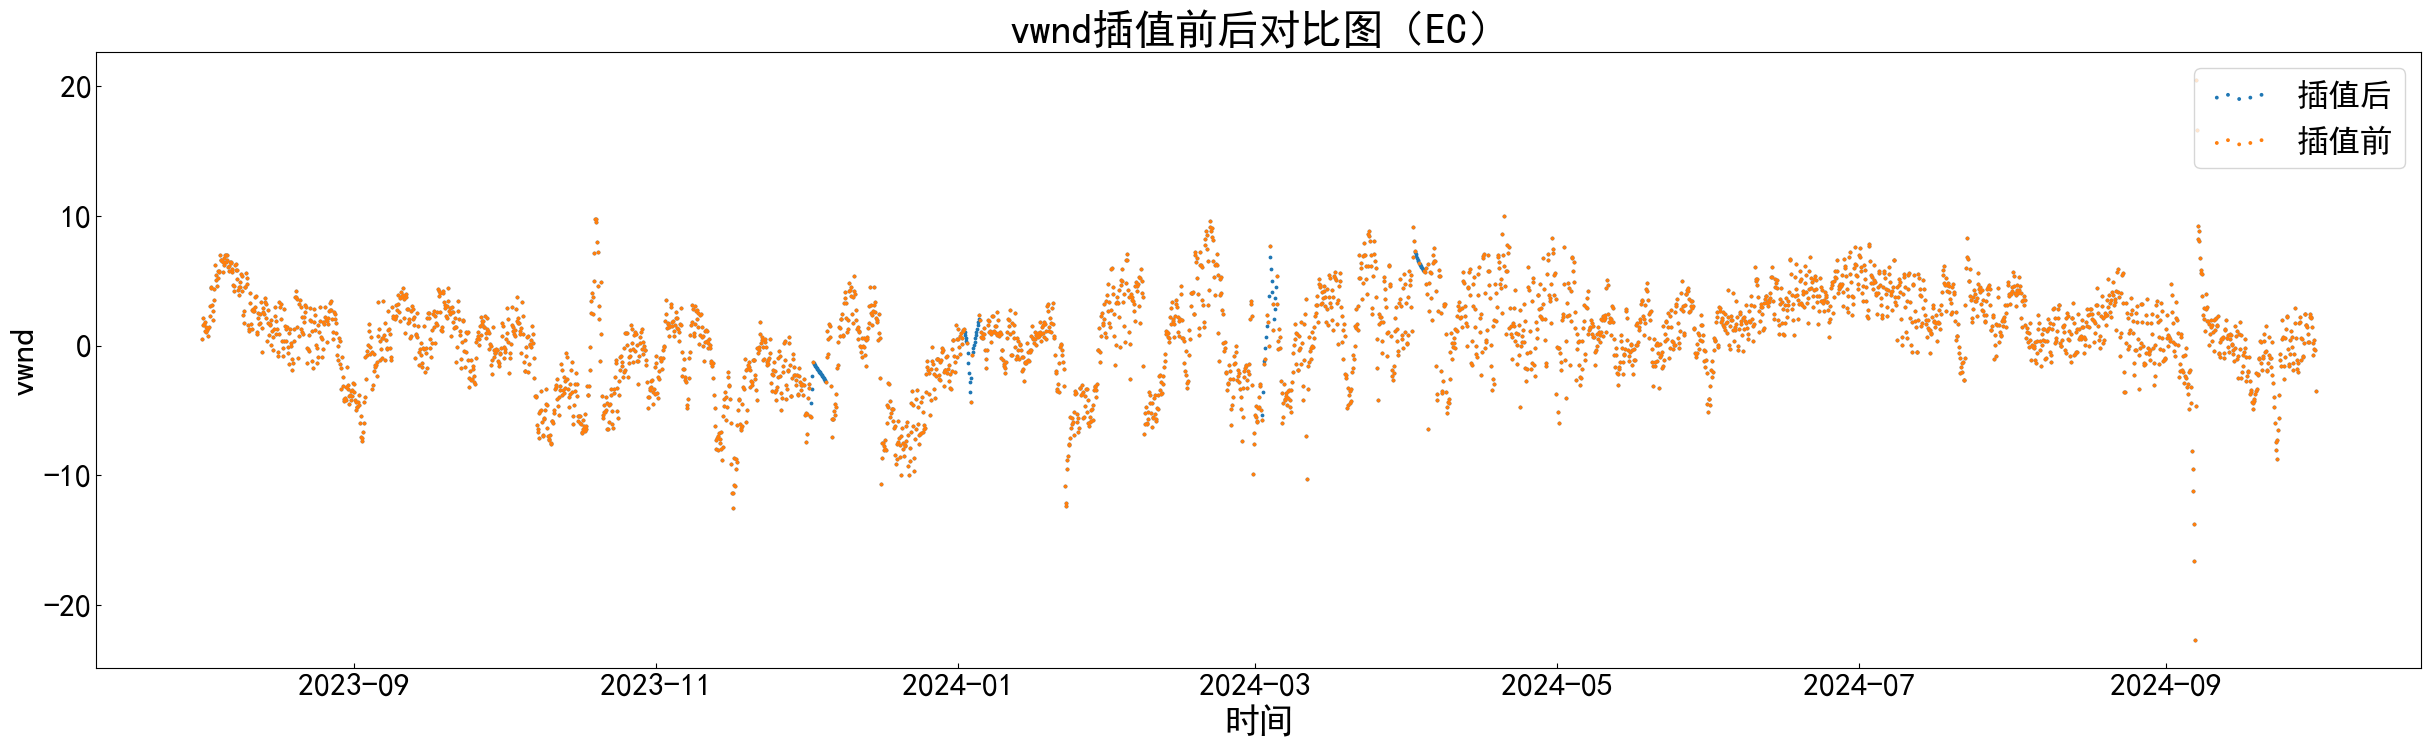

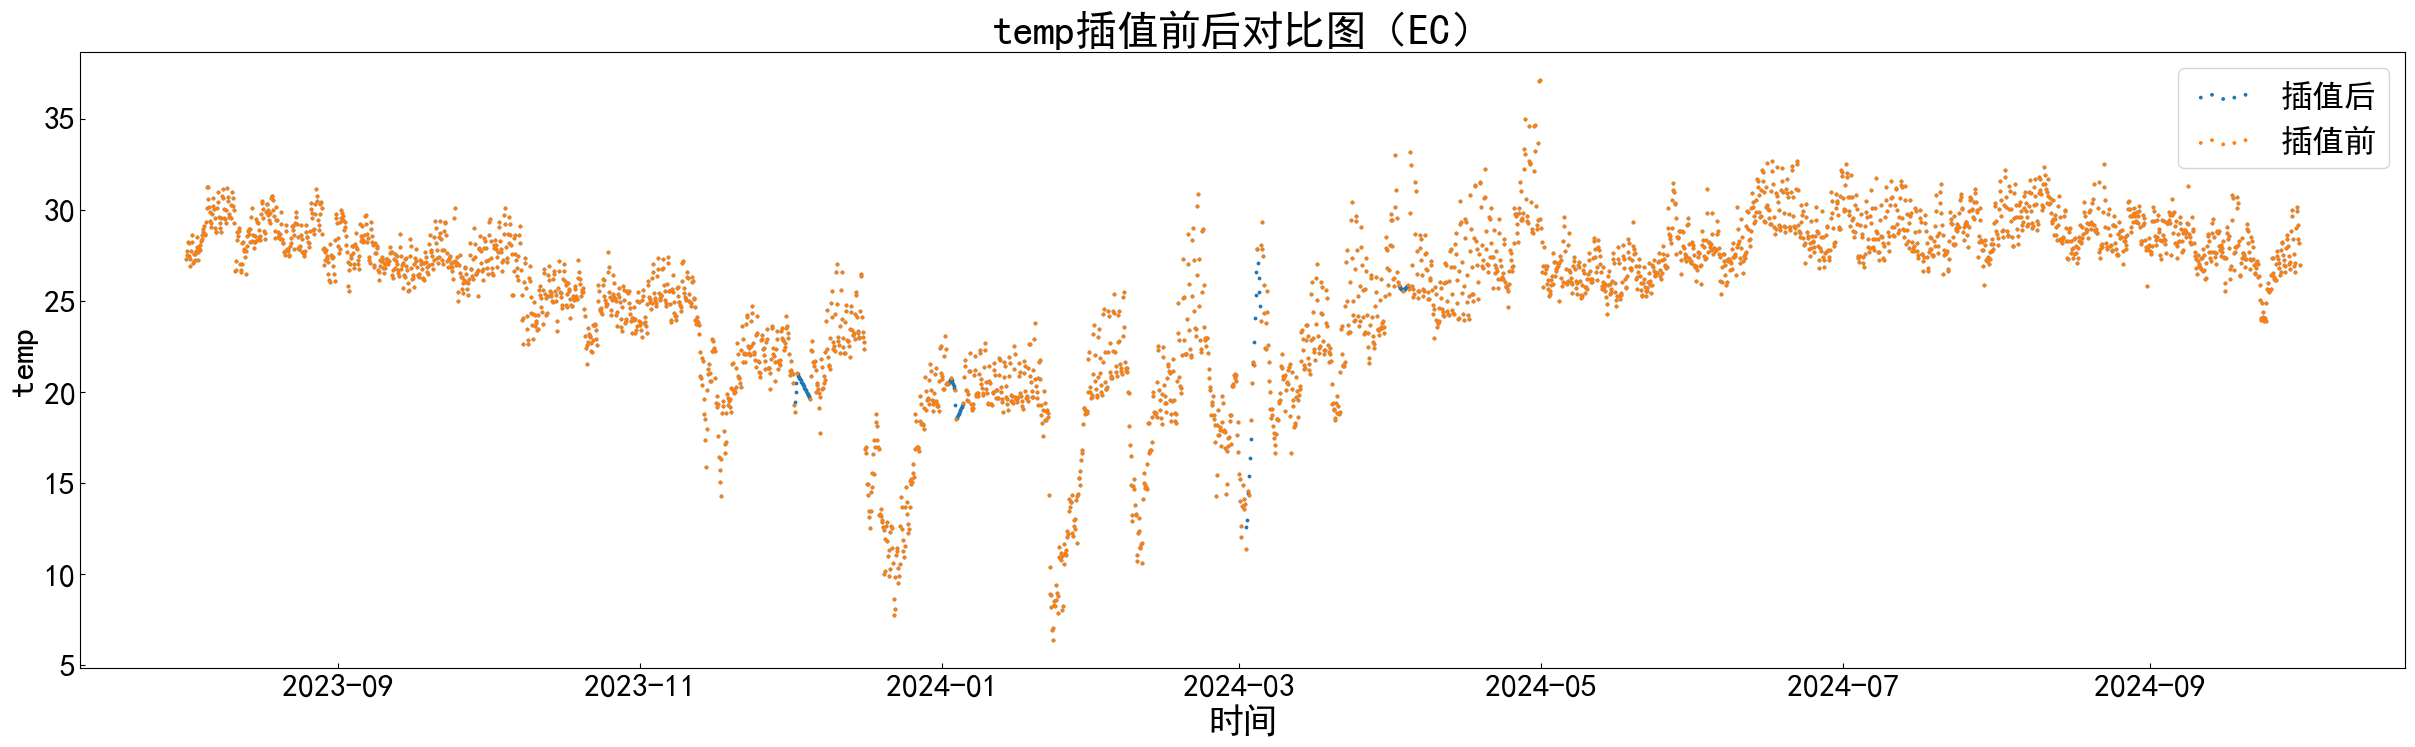

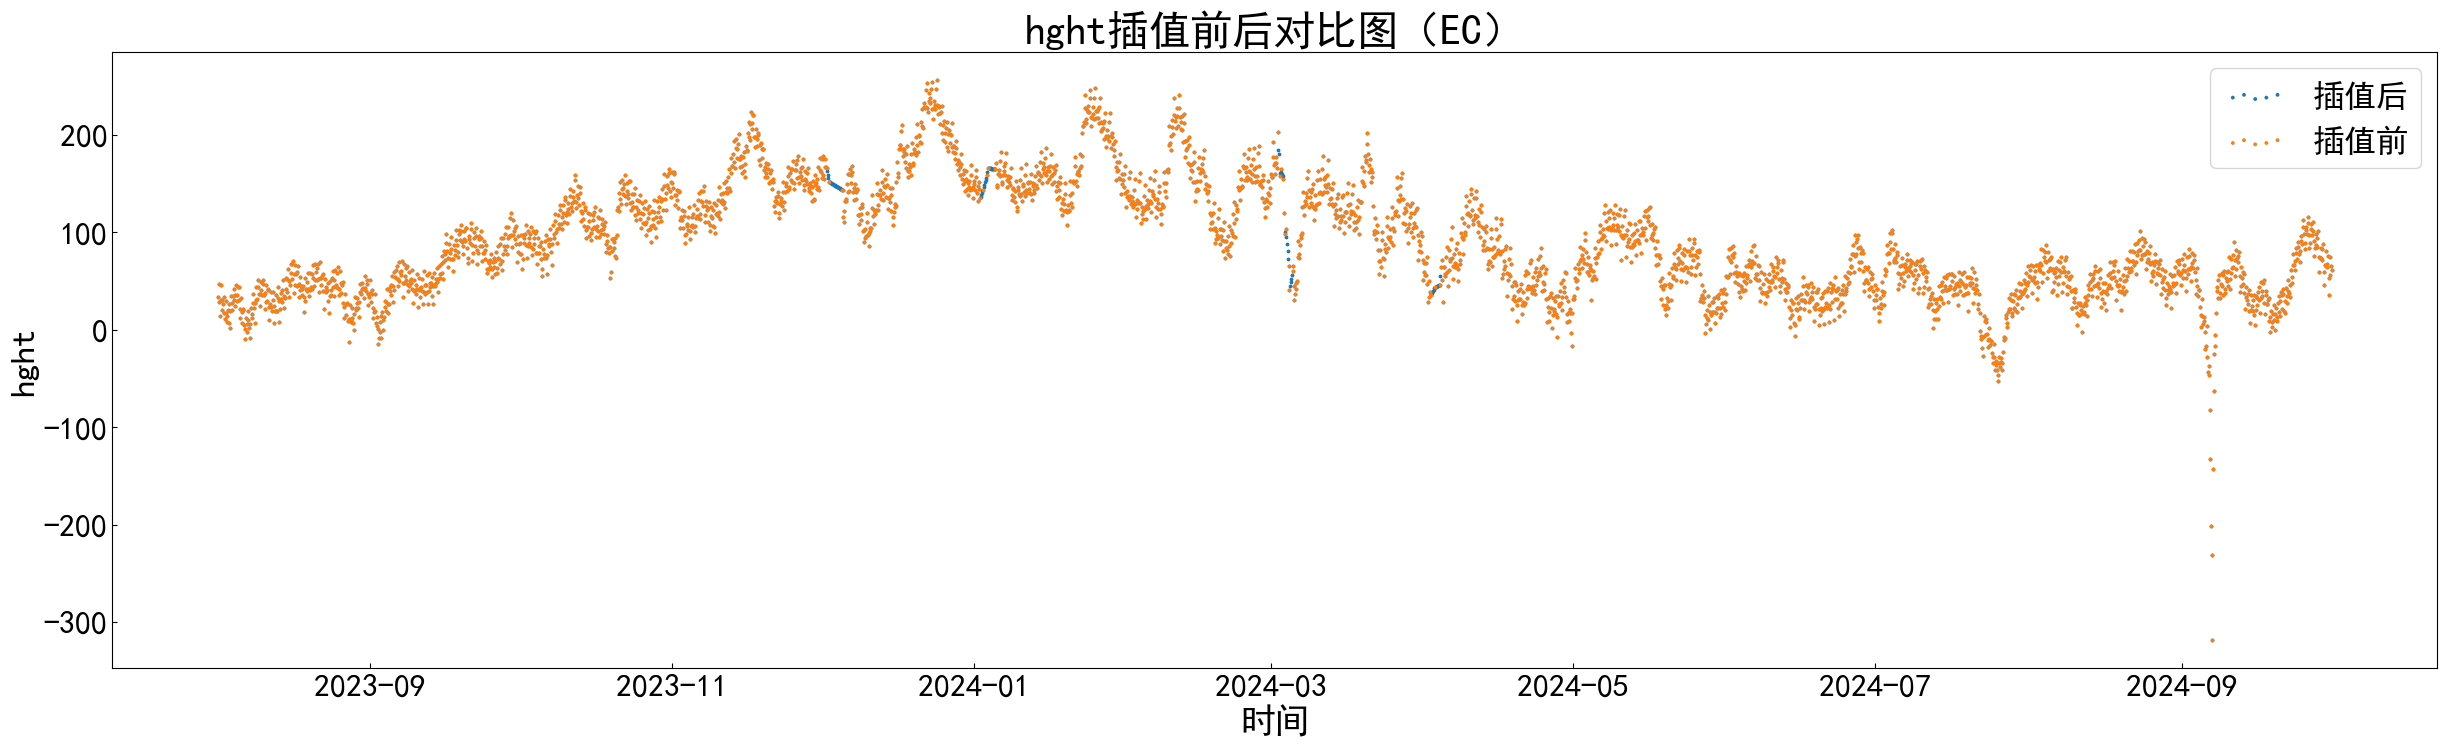

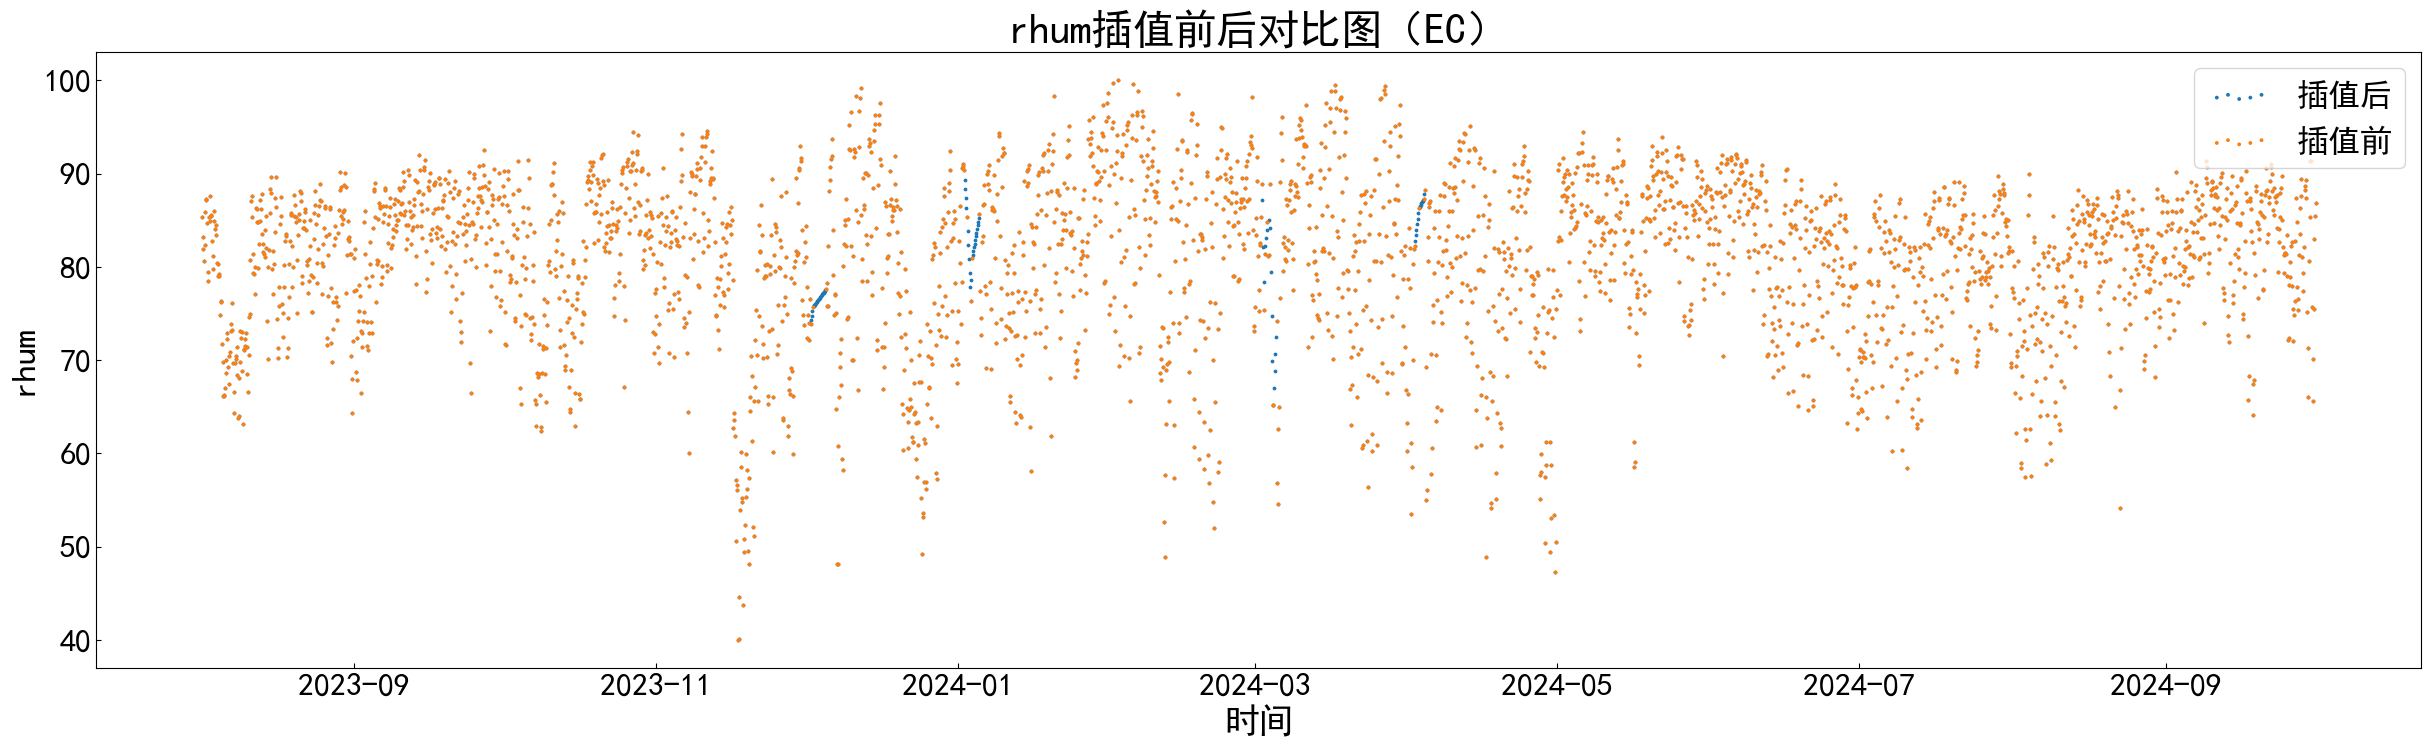

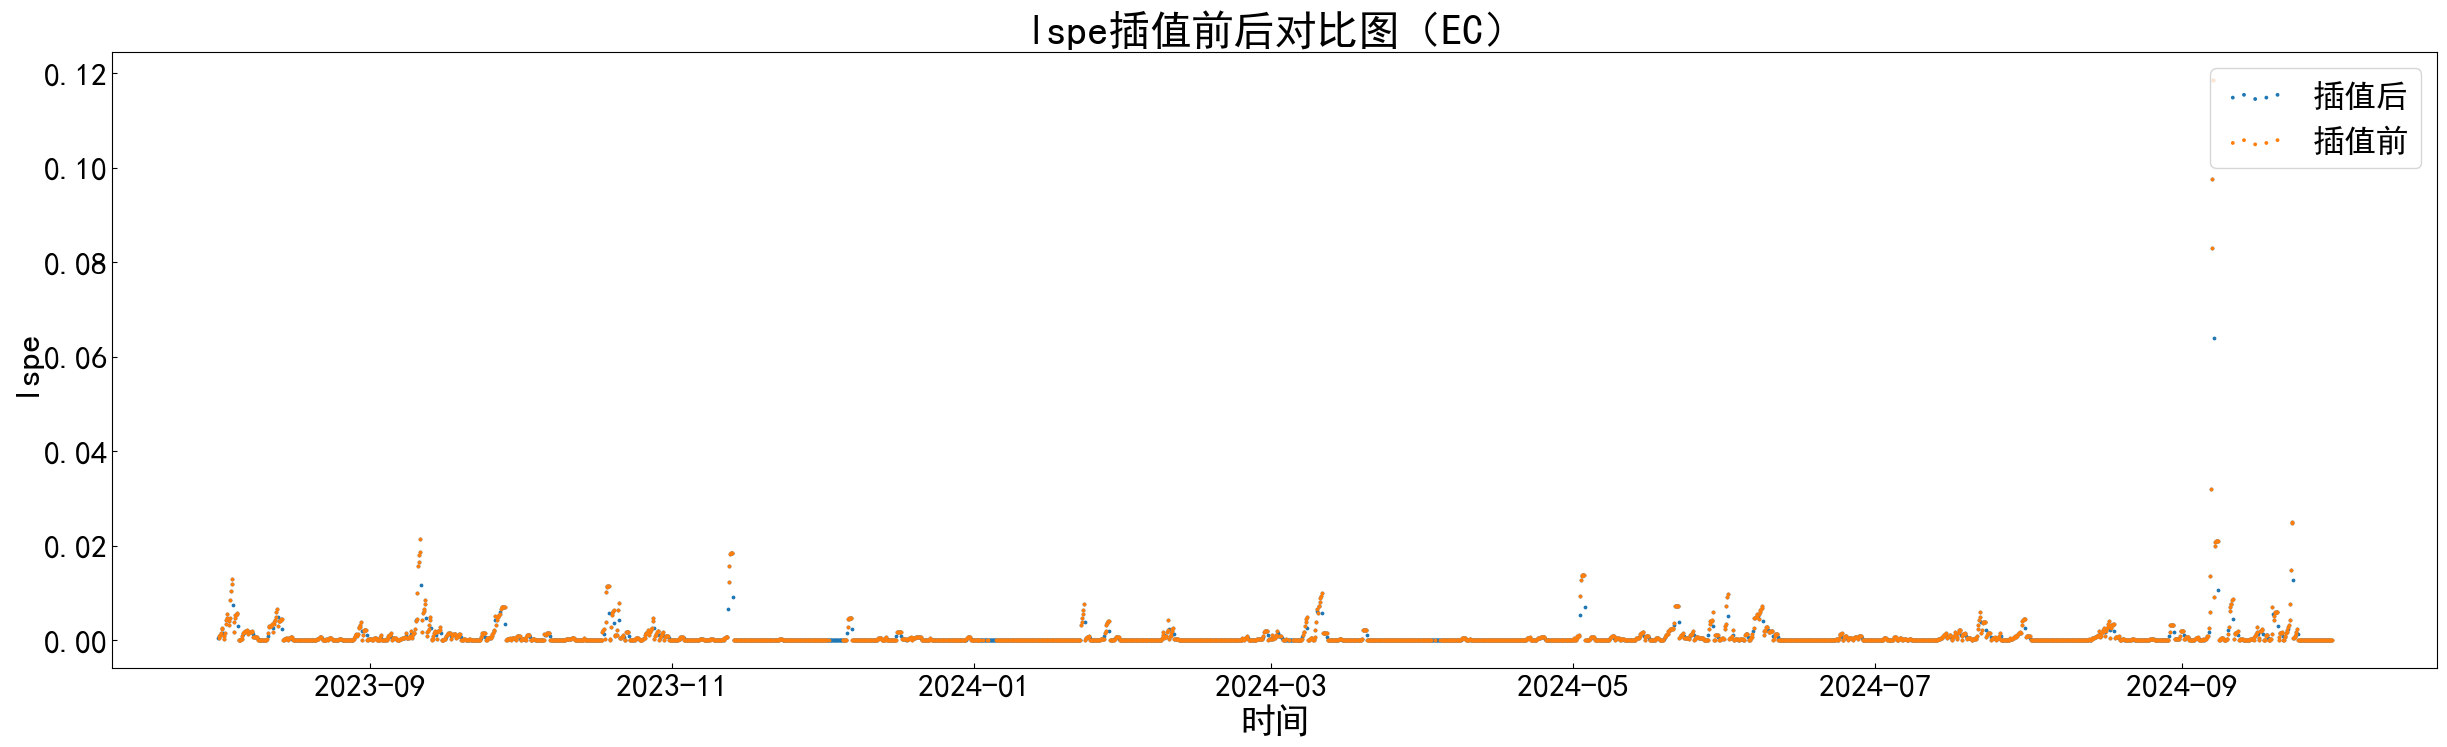

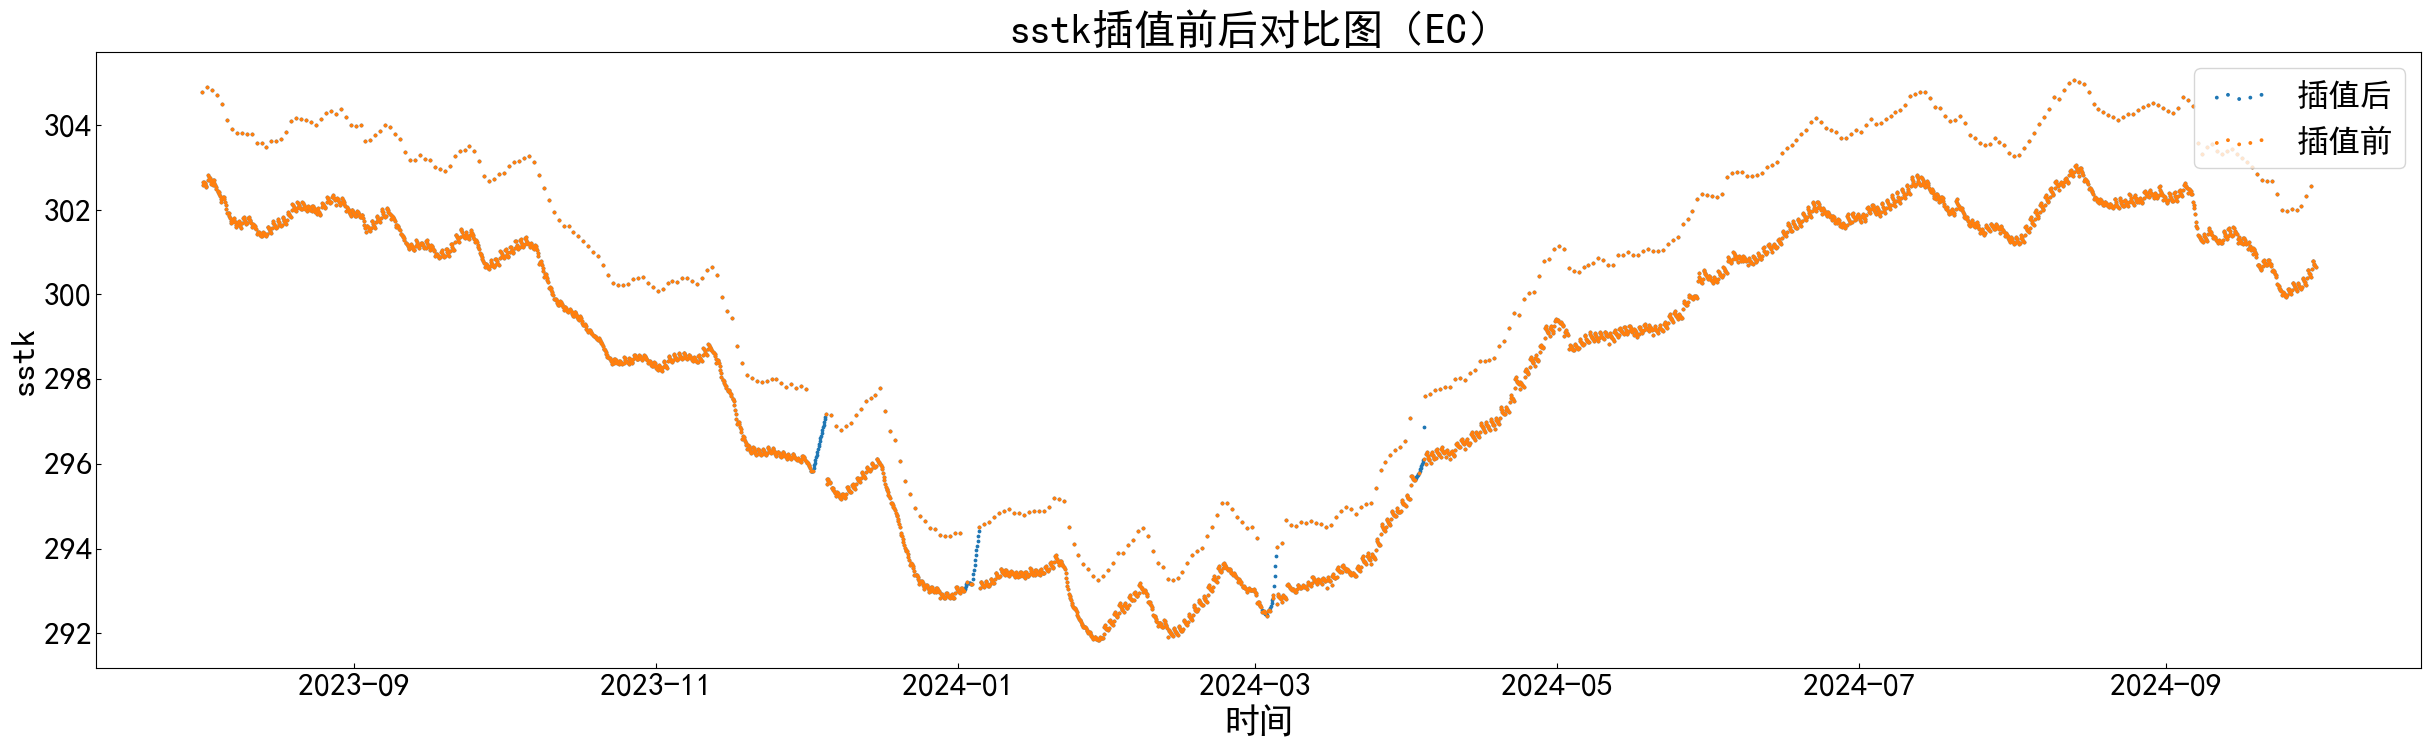

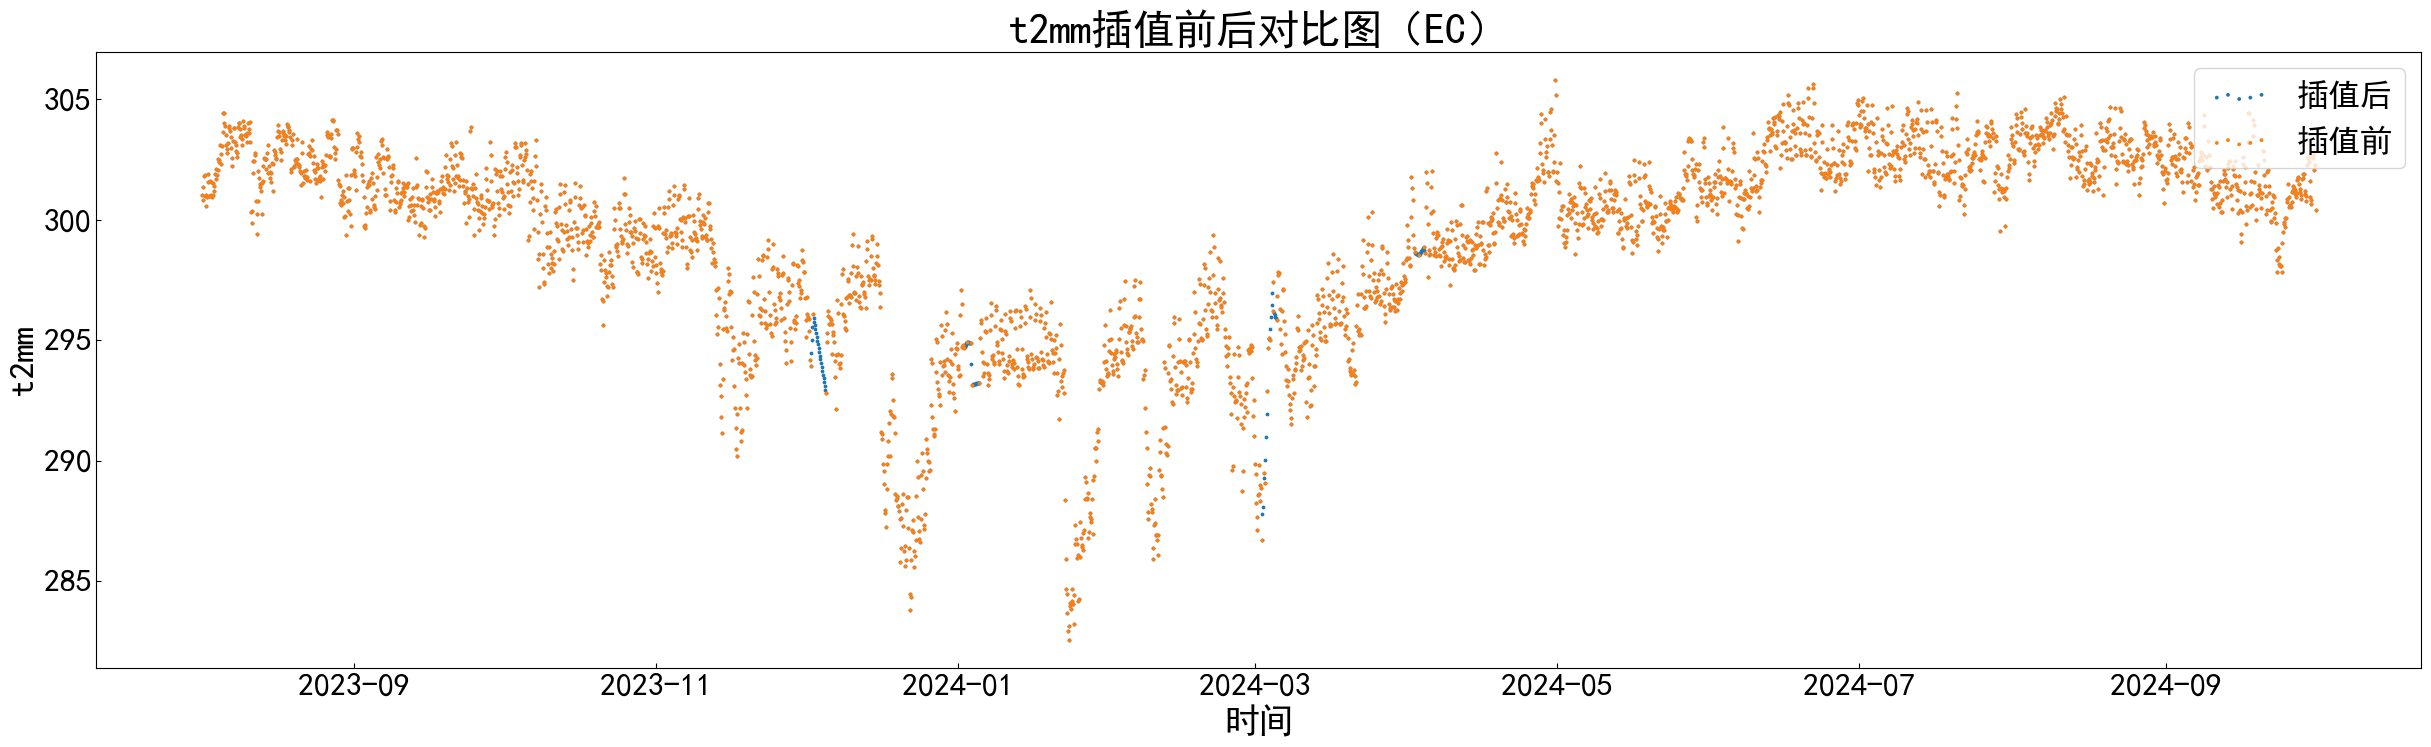

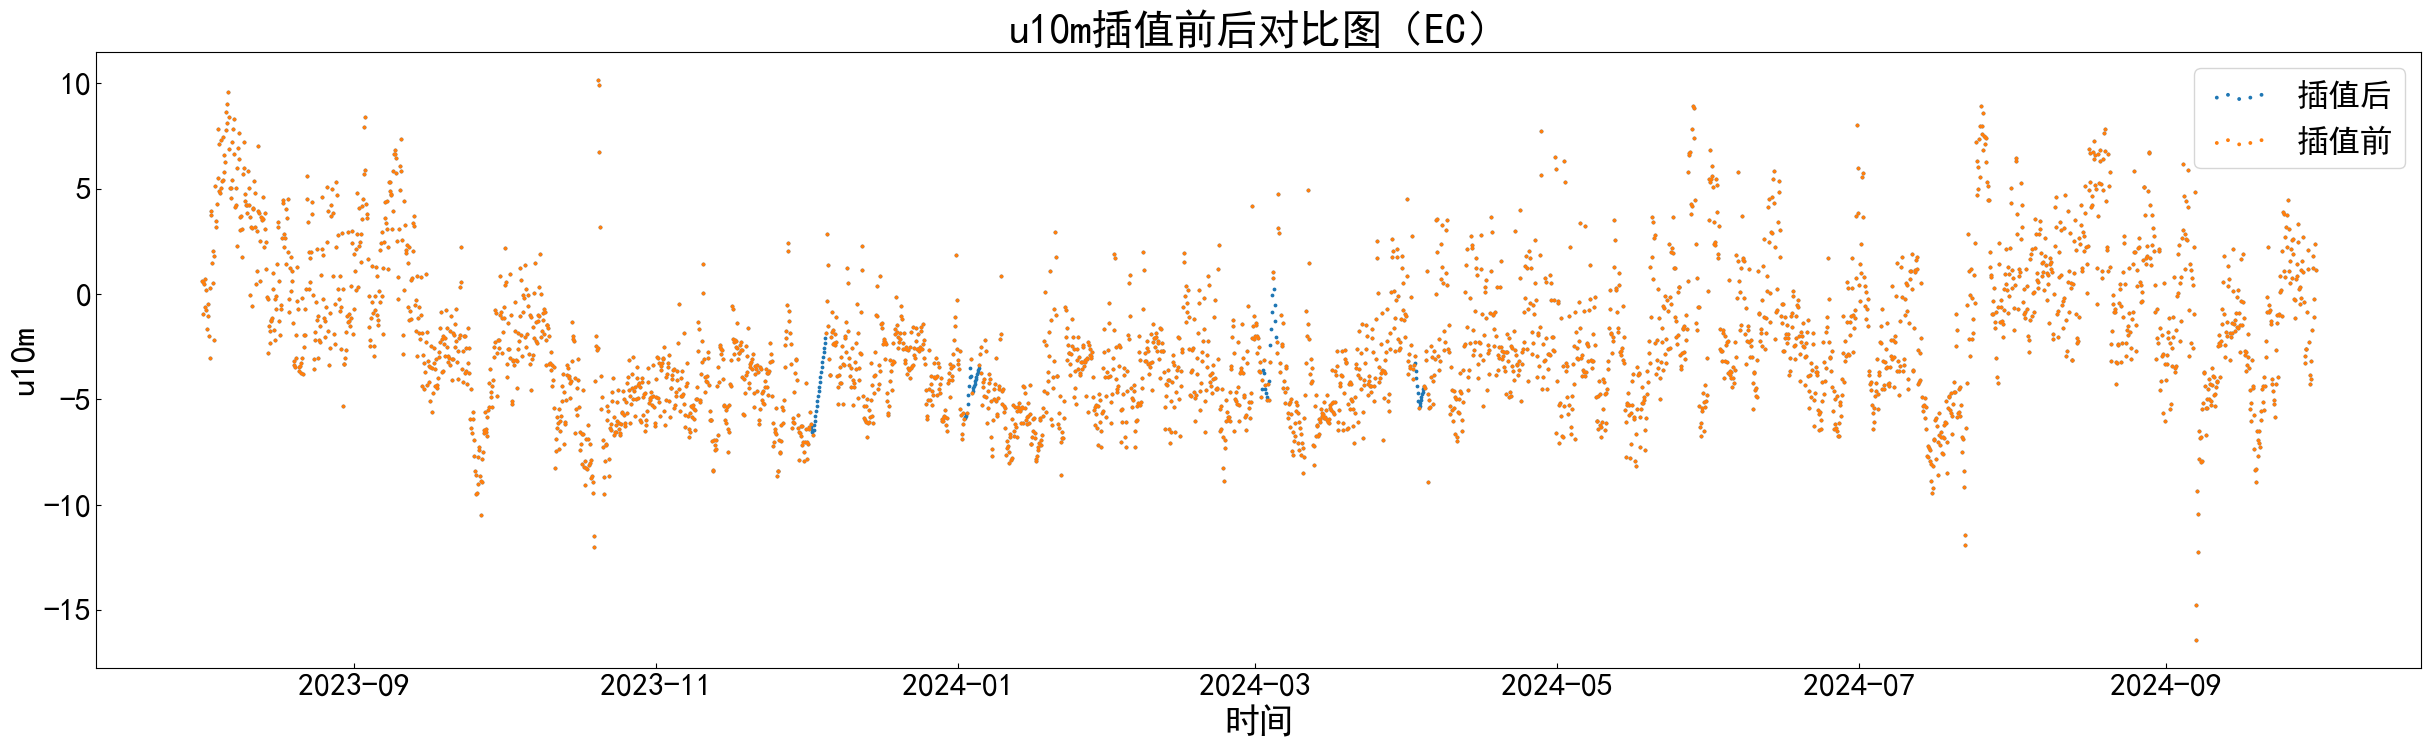

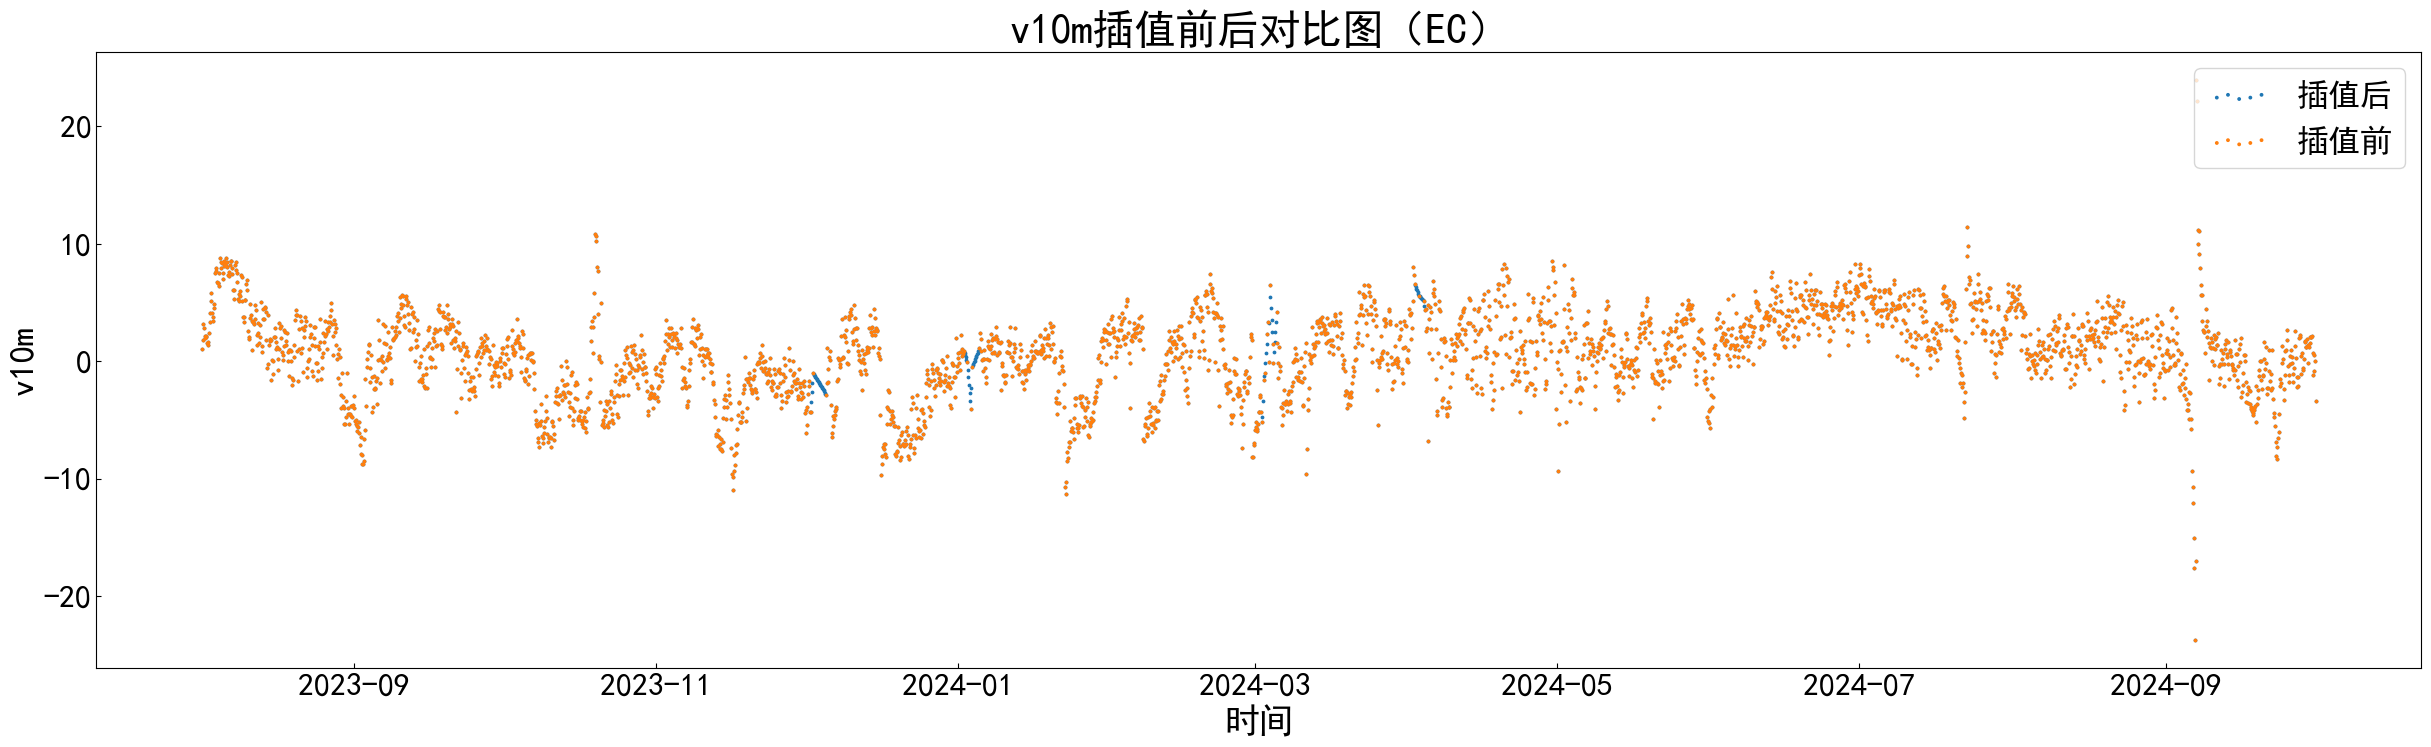

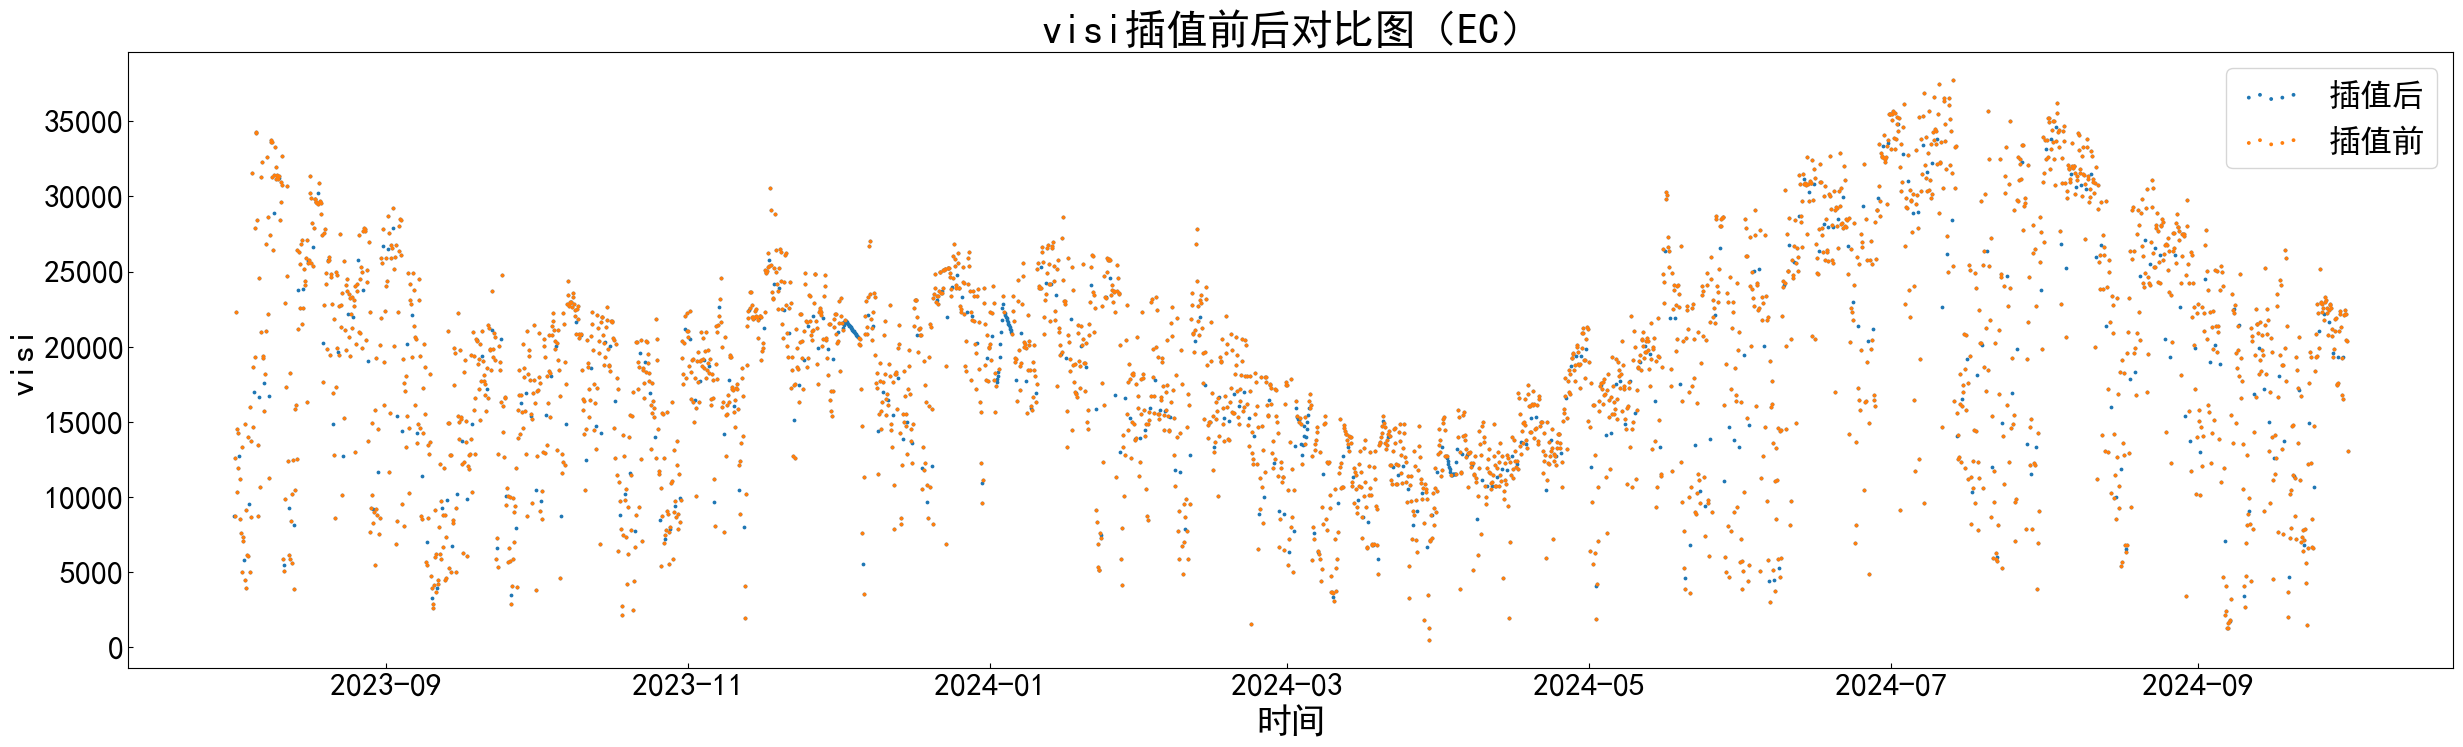

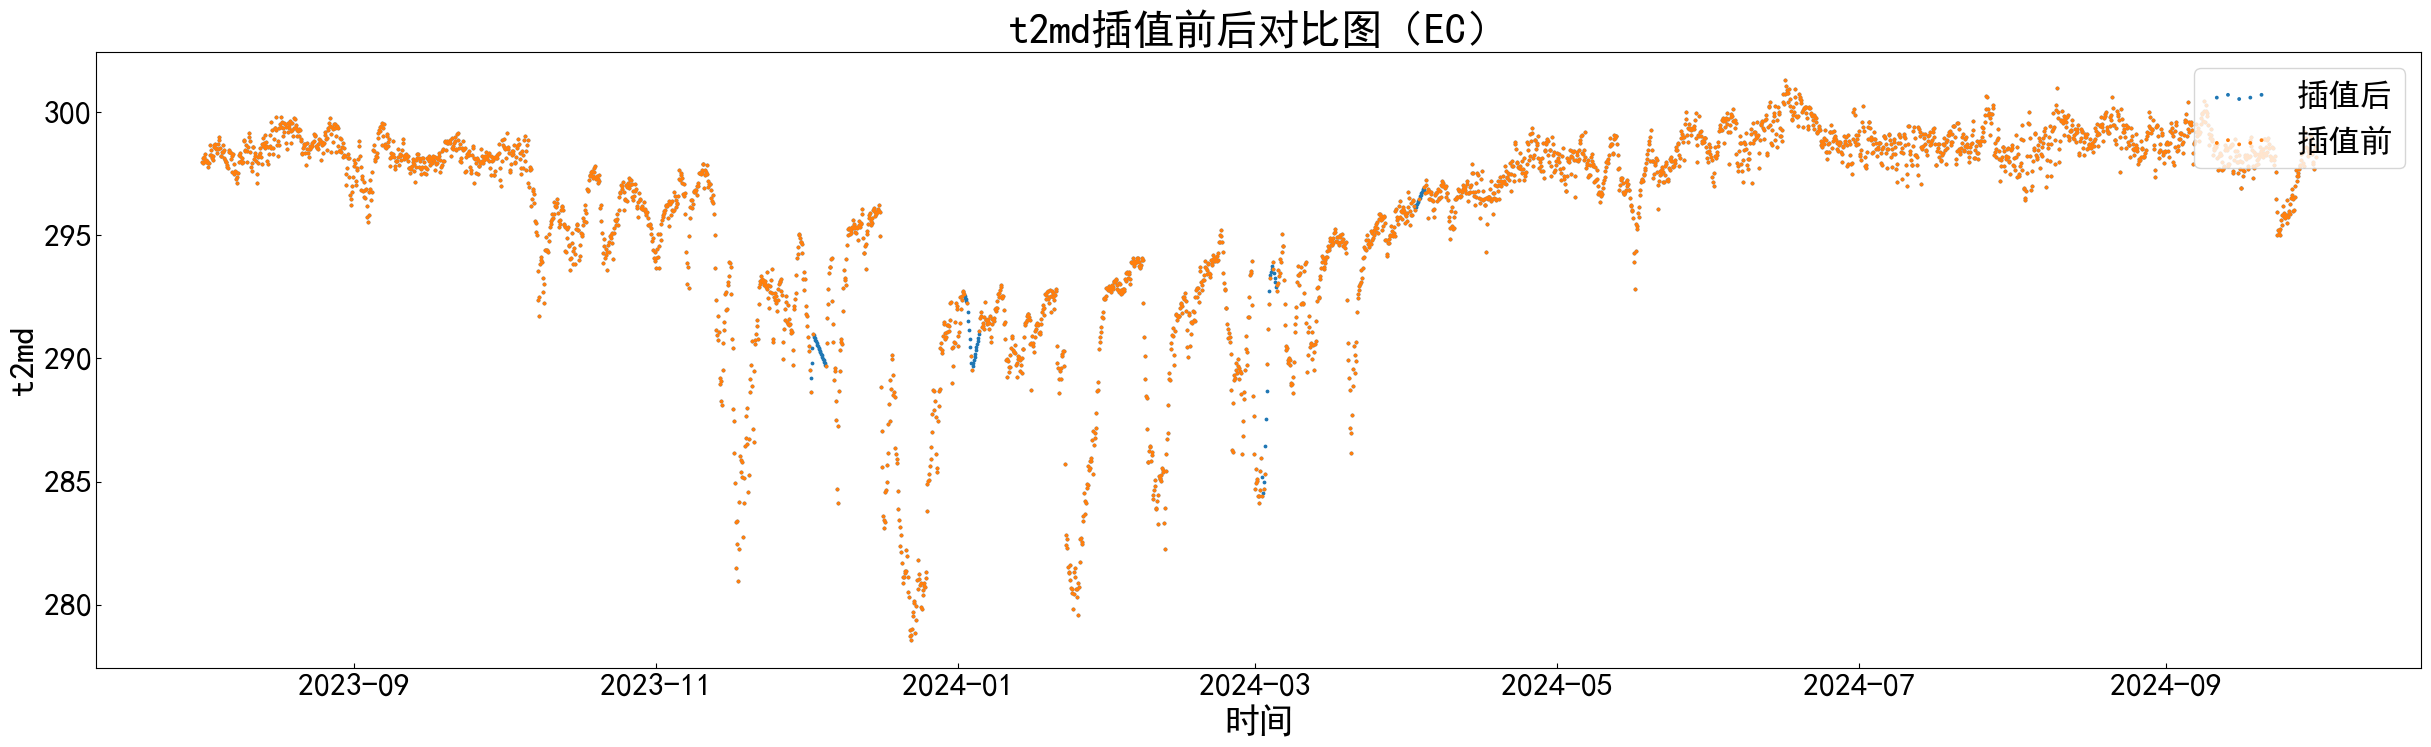

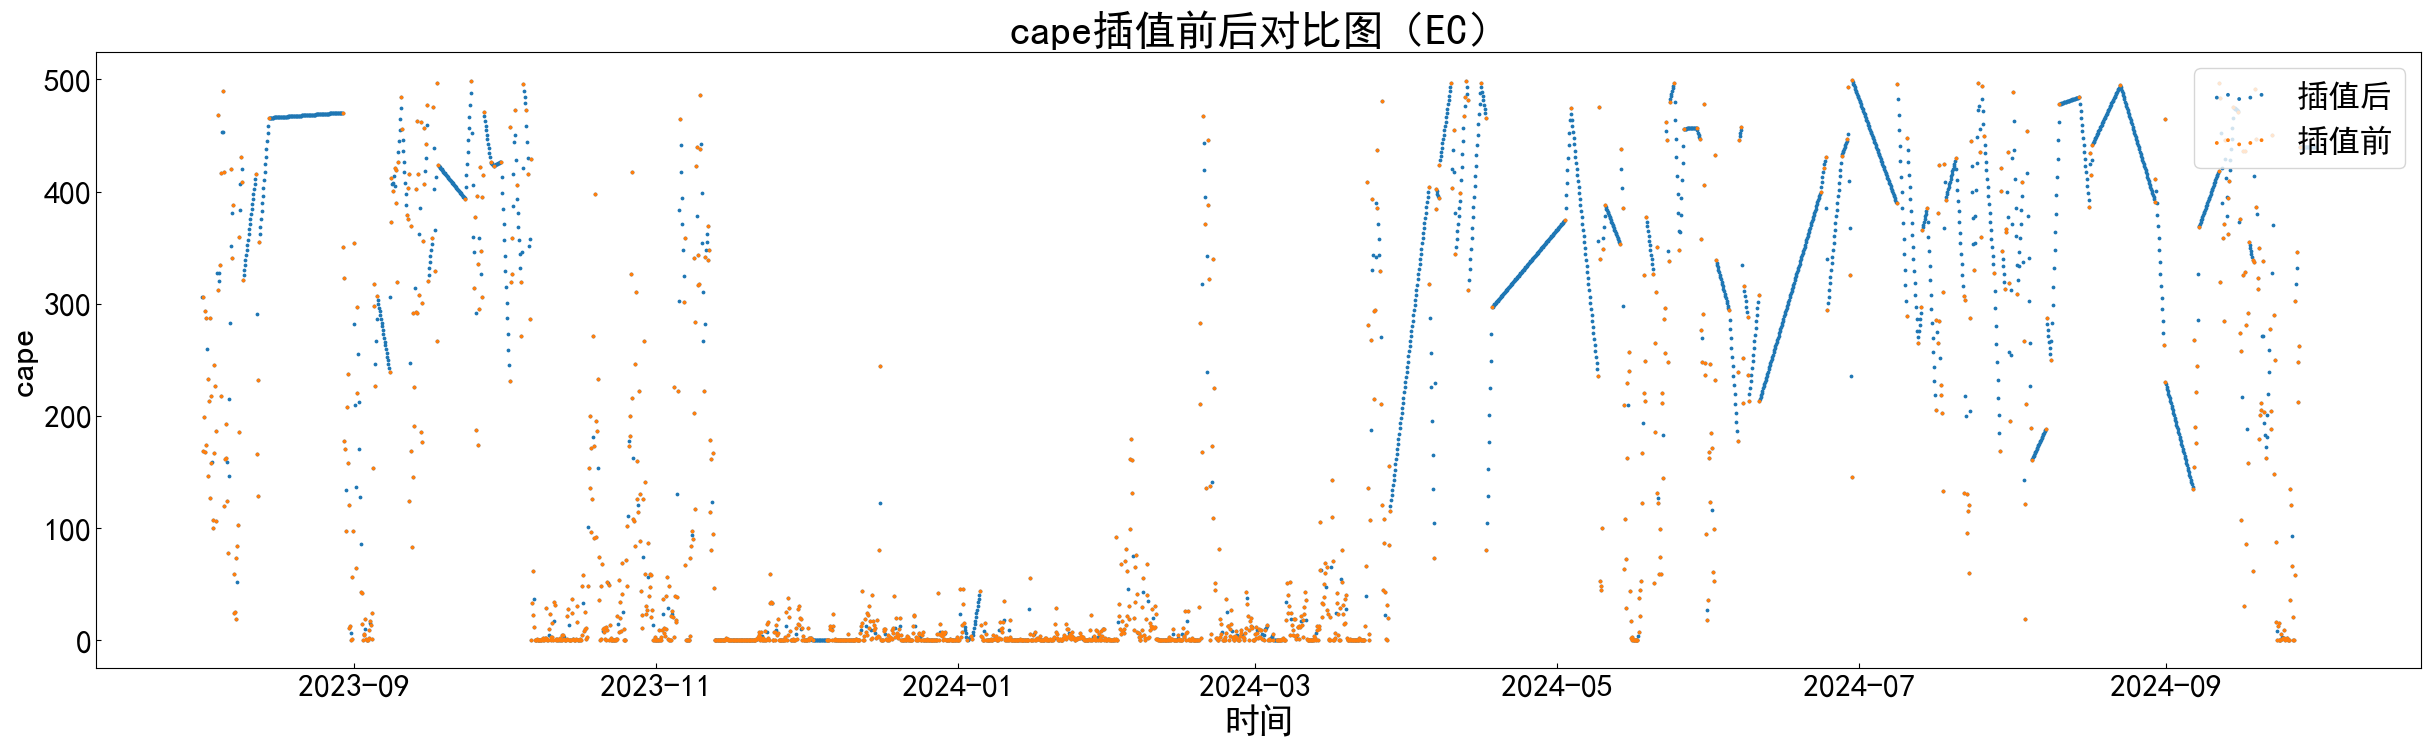

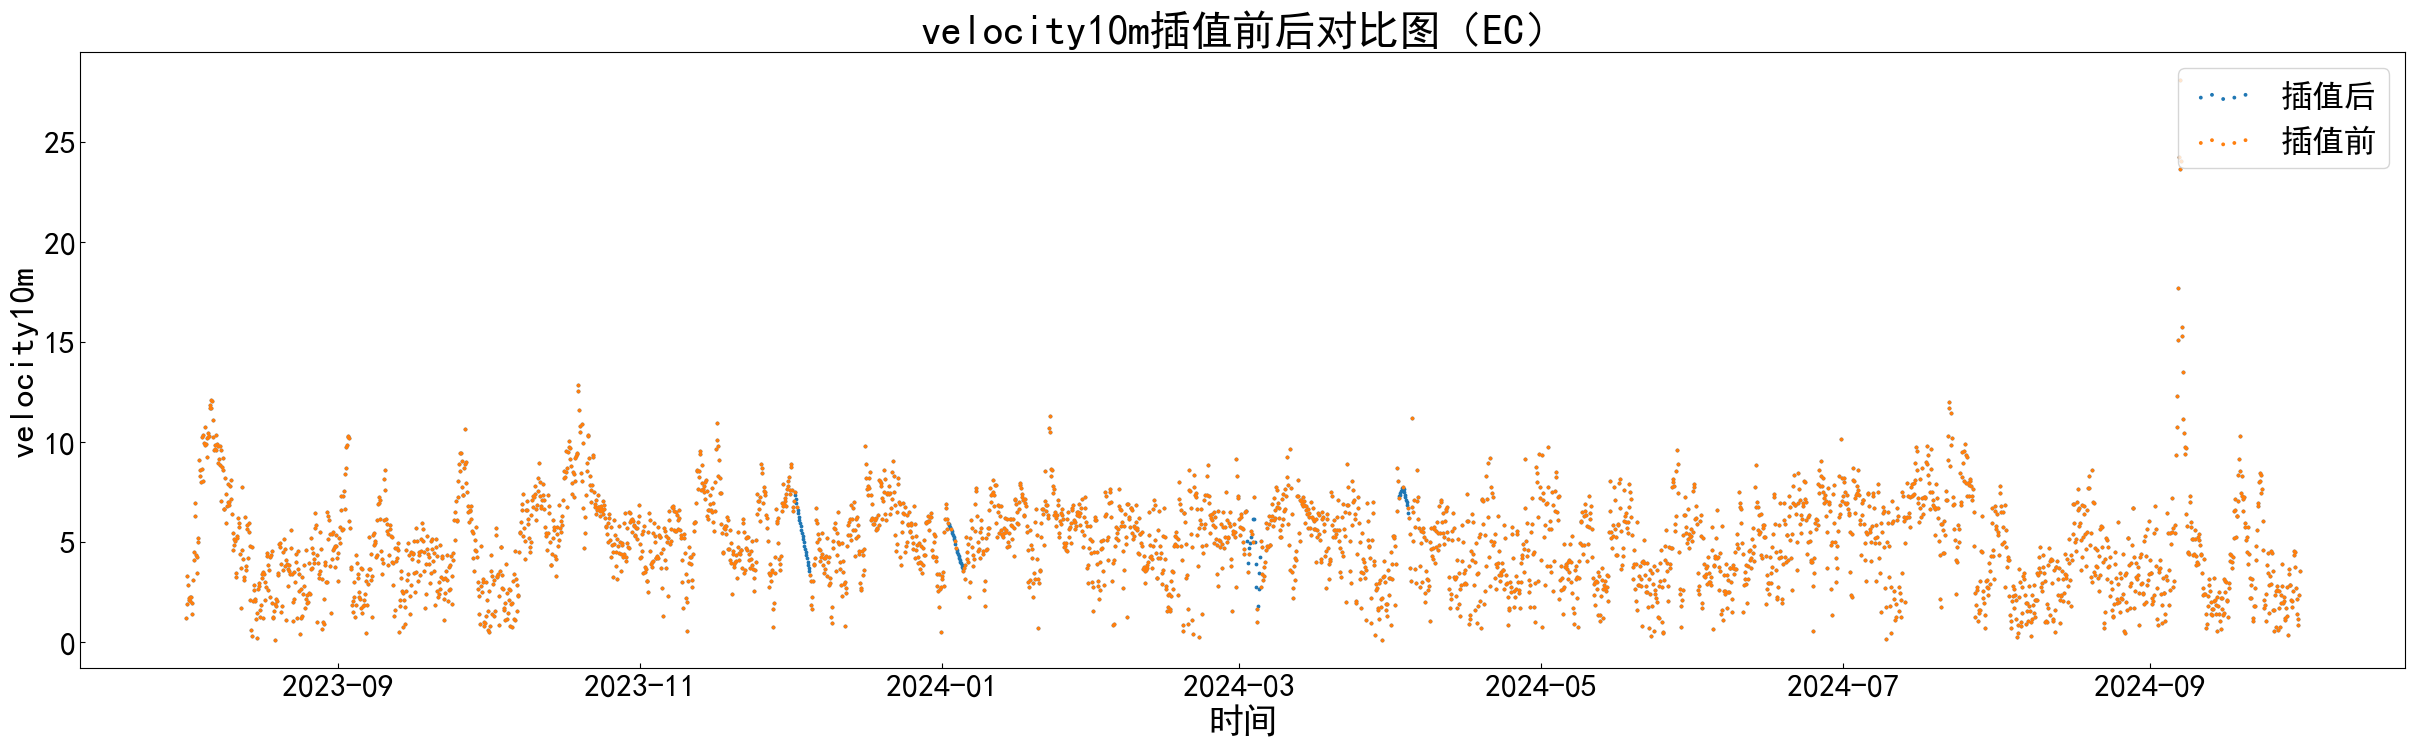

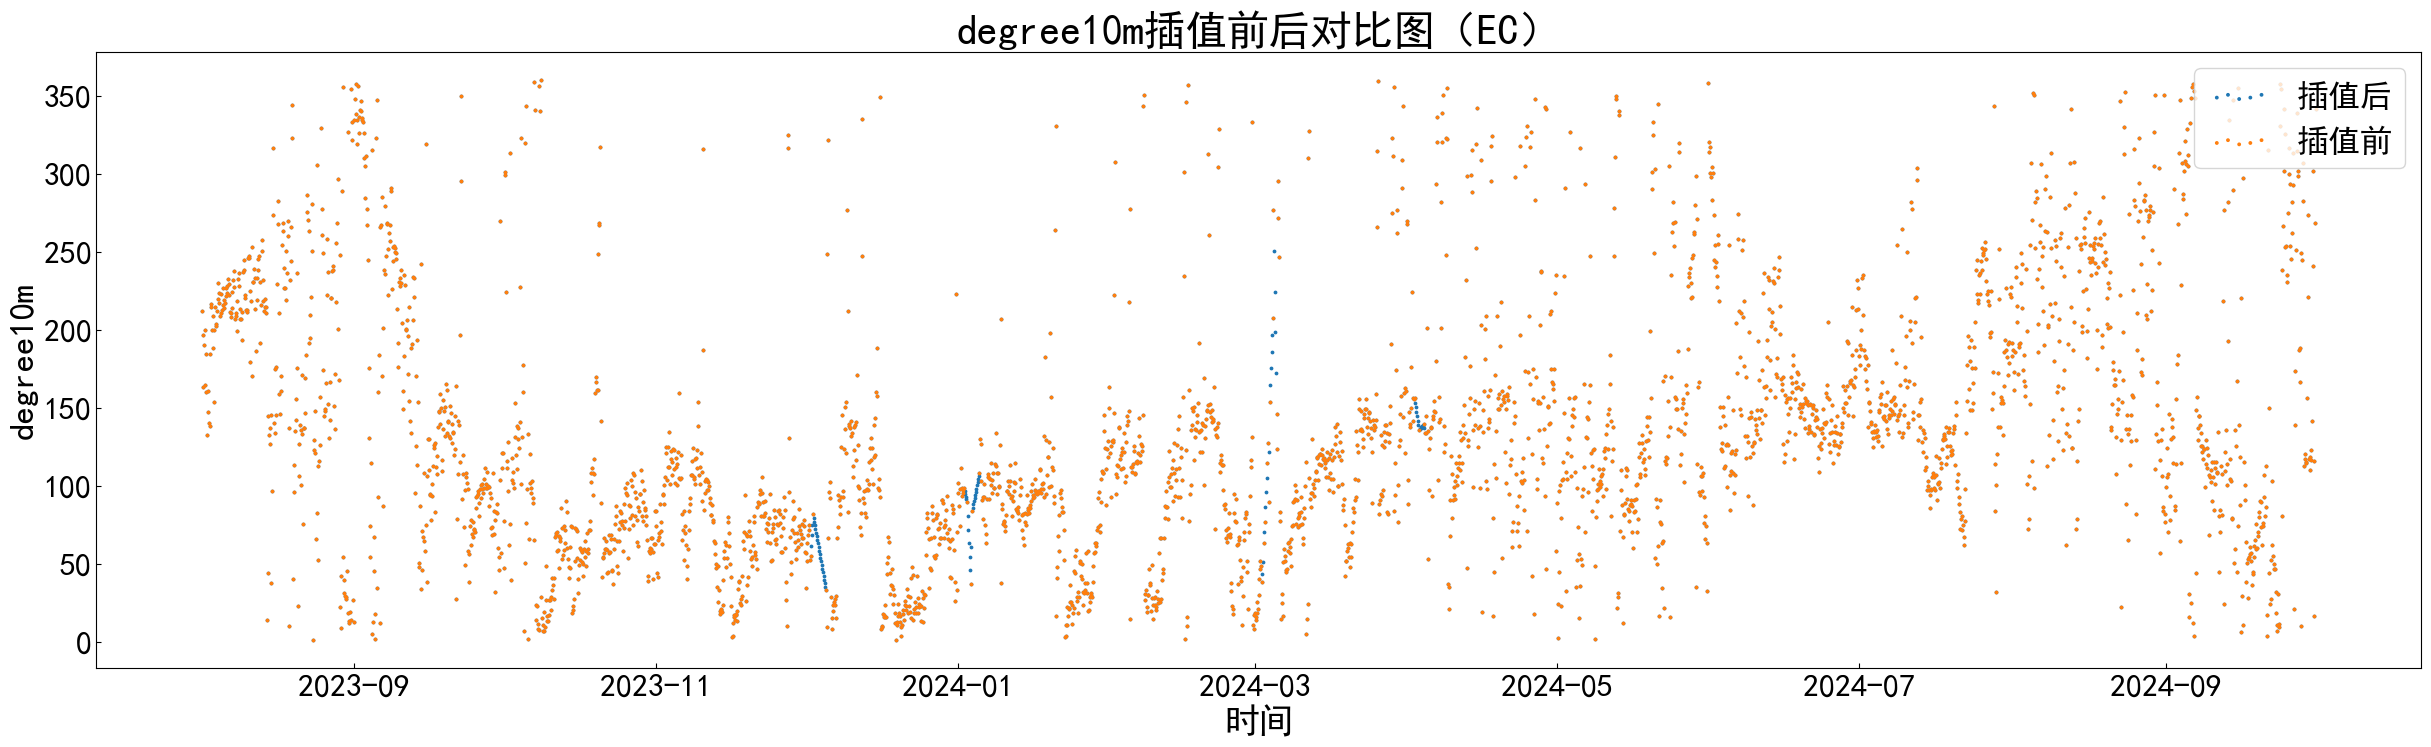

In [40]:
for var in interpolated_values:
    if var in time_axis_drop:
        plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
        plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
        size = 3
        line_width = 1
        
        plt.figure(figsize=(30, 8))
        
        plt.scatter(pd.to_datetime(time_axis_target), interpolated_values[var], linewidth = line_width, s=size, 
                    label='插值后')
        plt.scatter(time_axis_drop[var].squeeze(), filtered_dict_drop[var], linewidth = line_width, s=size,
                    label='插值前')
        
        plt.tick_params(direction='in', labelsize=23)
        plt.xlabel('时间', fontsize=25)
        plt.ylabel('{}'.format(var), fontsize=25)
        plt.legend(scatterpoints = 5, loc='upper right', fontsize=23)
        plt.title('{}插值前后对比图（EC）'.format(var), fontsize=30)
        # plt.savefig('../pic_01/风速插值前后对比图（EC）', dpi=300, bbox_inches='tight')
        plt.show()